This Notebook is for removing outliers from our dataset. Currently we remove businesses that have a low number of orders (below the 1% quantile.) We then generate some distribution plots and compare it to our plots from distribution_analysis.ipynb. 

In [1]:
from pyspark.sql import SparkSession, functions as F
from pyspark.sql.functions import col, to_date, when, concat, lit
import matplotlib.pyplot as plt


spark = SparkSession.builder \
    .appName("green preprocessing") \
    .config("spark.sql.repl.eagerEval.enabled", True) \
    .config("spark.sql.parquet.cacheMetadata", "true") \
    .config("spark.sql.session.timeZone", "Etc/UTC") \
    .config("spark.executor.memory", "4g") \
    .config("spark.driver.memory", "4g") \
    .getOrCreate()

your 131072x1 screen size is bogus. expect trouble
23/10/01 21:43:13 WARN Utils: Your hostname, NivethanAsus resolves to a loopback address: 127.0.1.1; using 172.23.153.212 instead (on interface eth0)
23/10/01 21:43:13 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/10/01 21:43:15 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [2]:
path1 = "../../../data/insights/joined.parquet"
df = spark.read.parquet(path1)
df.show(5)
df.printSchema()
print("length:",df.count())
df_pandas = df.toPandas()



23/10/01 21:43:26 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


+------------+--------------------+-------------+---------+----------------------------------+--------------------------+----------------------------------+--------------------------+----------------------------------------+----------------+---------------------+--------------------------+------------------------------+-------------------------+------------------------+------------------------+--------------------------+-------------------------+-------------------------+-------------------+--------------------------------+---------------------------+-----------------+------------------+------------------+---------------------------------+--------------------+
|merchant_abn|                name|revenue_level|take_rate|average_merchant_fraud_probability|number_of_unique_consumers|average_consumer_fraud_probability|number_of_repeat_consumers|average_repeat_transactions_per_consumer|number_of_orders|average_cost_of_order|average_spend_per_consumer|average_monthly_diff_consumers|consumer_d

tech_and_electronics


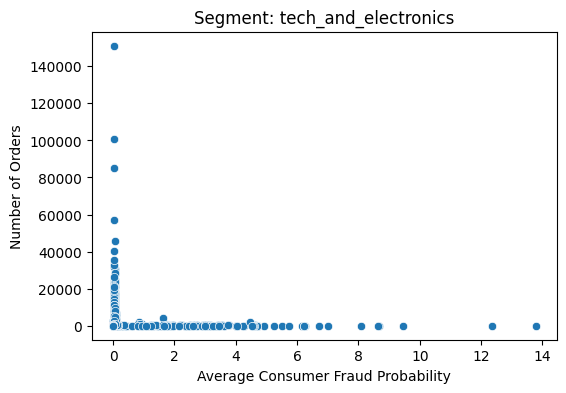

antiques_and_jewellery


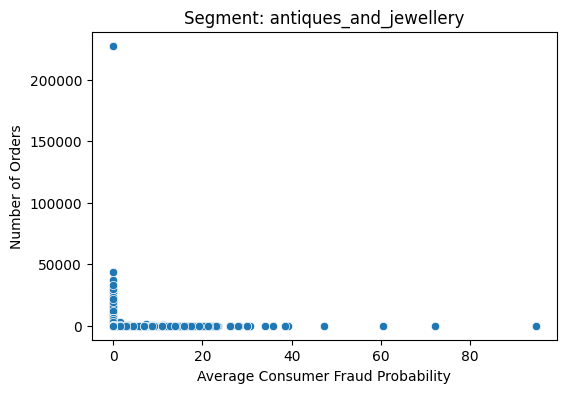

specialized_services


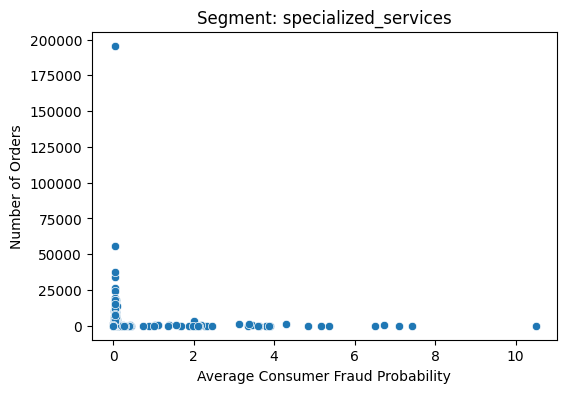

garden_and_furnishings


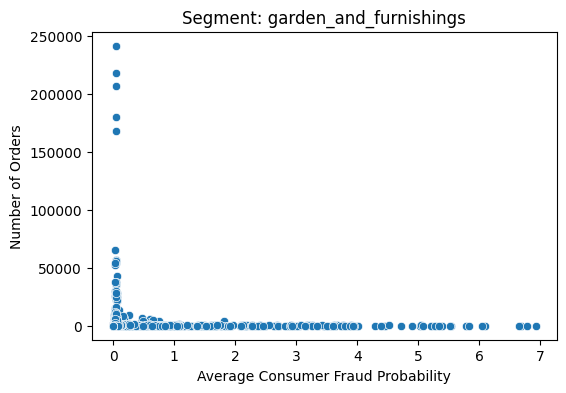

retail_and_novelty


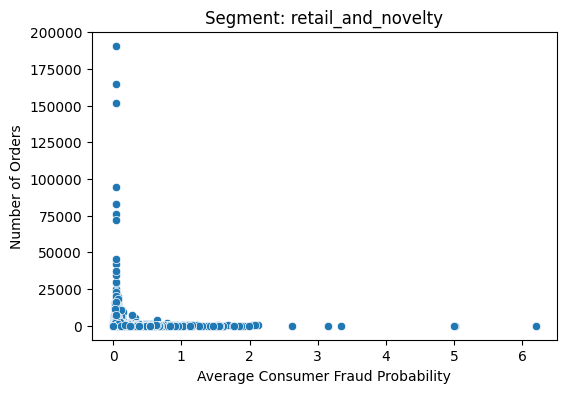

In [3]:
import pandas as pd
import seaborn as sns
# Initialize an empty list to hold the outliers

for segment in df_pandas['segment'].unique():
    # Filter the dataframe for each segment
    segment_df = df_pandas[df_pandas['segment'] == segment]
    print(segment)
    plt.figure(figsize=(6,4))
    sns.scatterplot(x='average_consumer_fraud_probability', y='number_of_orders', data=segment_df)
    plt.title(f'Segment: {segment}')
    plt.xlabel('Average Consumer Fraud Probability')
    plt.ylabel('Number of Orders')
    plt.show()


In [4]:
import pandas as pd
import seaborn as sns
# Initialize an empty list to hold the outliers

# Define a function to calculate upper bound outliers
def get_outliers(df, column_name):
    lower_bound = df[column_name].quantile(0.01)
    print(lower_bound)
    return df[df[column_name] <= lower_bound], lower_bound

outliers_list,lower_bound = get_outliers(df_pandas,'number_of_orders')
    
# Create a DataFrame from the outliers_list
outliers_df = pd.DataFrame(outliers_list)
display(outliers_df)
print("length: ",len(outliers_df))

3.0


,merchant_abn,name,revenue_level,take_rate,average_merchant_fraud_probability,number_of_unique_consumers,average_consumer_fraud_probability,number_of_repeat_consumers,average_repeat_transactions_per_consumer,number_of_orders,...,last_recorded_transaction,transcation_period_months,number_of_postcodes,avg_total_weekly_personal_income,avg_total_weekly_fam_income,avg_median_age,avg_household_size,postcode_reach,avg_num_of_consumers_per_postcode,segment
55,24526454463,Penatibus Limited,c,2.95,0.0,3,0.000000,0,1.0,3,...,2022-03-04,-0.741935,3,672.000000,1647.333333,47.833333,2.393333,0.001137,1.0,antiques_and_jewellery
779,99776743787,Non Luctus Sit Limited,b,3.61,0.0,3,3.335000,0,1.0,3,...,2022-09-06,11.709677,3,1012.500000,2496.500000,42.000000,2.283333,0.001137,1.0,antiques_and_jewellery
801,89133730546,Adipiscing Fringilla Porttitor Ltd,b,3.40,0.0,2,23.439650,0,1.0,2,...,2021-11-05,1.193548,2,864.000000,2555.500000,37.500000,2.250000,0.000758,1.0,antiques_and_jewellery
820,34455283435,Ac Fermentum Company,c,2.41,0.0,3,16.243400,0,1.0,3,...,2022-10-06,15.129032,3,1088.666667,2546.666667,40.666667,2.366667,0.001137,1.0,antiques_and_jewellery
1116,20884516643,Faucibus Orci Industries,c,2.24,0.0,3,3.911100,0,1.0,3,...,2022-06-19,13.483871,3,870.666667,2246.166667,39.500000,2.643333,0.001137,1.0,specialized_services
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4021,55403018592,Elit Limited,b,4.84,0.0,2,0.000000,0,1.0,2,...,2022-06-23,2.064516,2,503.000000,1229.500000,54.000000,2.100000,0.000758,1.0,antiques_and_jewellery
4022,29068447069,Phasellus LLP,b,3.28,0.0,1,72.205600,0,1.0,1,...,2021-09-21,0.000000,1,796.000000,1855.000000,43.000000,2.300000,0.000379,1.0,antiques_and_jewellery
4023,22853038342,Semper Pretium Limited,a,5.56,0.0,2,0.000000,0,1.0,2,...,2022-06-29,12.032258,2,753.500000,1781.500000,44.000000,2.450000,0.000758,1.0,antiques_and_jewellery
4024,64143552561,Fusce Feugiat Associates,a,5.88,0.0,3,21.174067,0,1.0,3,...,2022-04-22,11.161290,3,623.666667,1527.666667,49.000000,2.333333,0.001137,1.0,antiques_and_jewellery


length:  61


In [5]:
grouped_outliers = outliers_df.groupby('segment').size().reset_index(name='count')
display(grouped_outliers)
display("outlier_merchant_fraud",outliers_df.groupby('segment')['average_merchant_fraud_probability'].describe().reset_index())
display("outlier_consumer_fraud",outliers_df.groupby('segment')['average_consumer_fraud_probability'].describe().reset_index())
display("cost of order",outliers_df.groupby('segment')['average_cost_of_order'].describe().reset_index())


,segment,count
0,antiques_and_jewellery,52
1,garden_and_furnishings,2
2,specialized_services,3
3,tech_and_electronics,4


'outlier_merchant_fraud'

,segment,count,mean,std,min,25%,50%,75%,max
0,antiques_and_jewellery,52.0,0.536582,2.837382,0.0,0.0,0.0,0.0,18.2109
1,garden_and_furnishings,2.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0000
2,specialized_services,3.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0000
3,tech_and_electronics,4.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0000


'outlier_consumer_fraud'

,segment,count,mean,std,min,25%,50%,75%,max
0,antiques_and_jewellery,52.0,16.346104,19.738839,0.000000,0.000000,11.523283,23.198863,94.70340
1,garden_and_furnishings,2.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
2,specialized_services,3.0,2.506711,2.176123,0.000000,1.804517,3.609033,3.760067,3.91110
3,tech_and_electronics,4.0,5.354046,2.832319,3.006767,3.794517,4.485583,6.045113,9.43825


'cost of order'

,segment,count,mean,std,min,25%,50%,75%,max
0,antiques_and_jewellery,52.0,15549.606891,10152.076216,2122.066667,8407.252500,14084.825000,19820.860000,51876.640000
1,garden_and_furnishings,2.0,3036.778333,204.148799,2892.423333,2964.600833,3036.778333,3108.955833,3181.133333
2,specialized_services,3.0,4977.725556,1362.339519,3404.703333,4577.955000,5751.206667,5764.236667,5777.266667
3,tech_and_electronics,4.0,4716.830833,857.448274,3734.290000,4313.767500,4663.706667,5066.770000,5805.620000


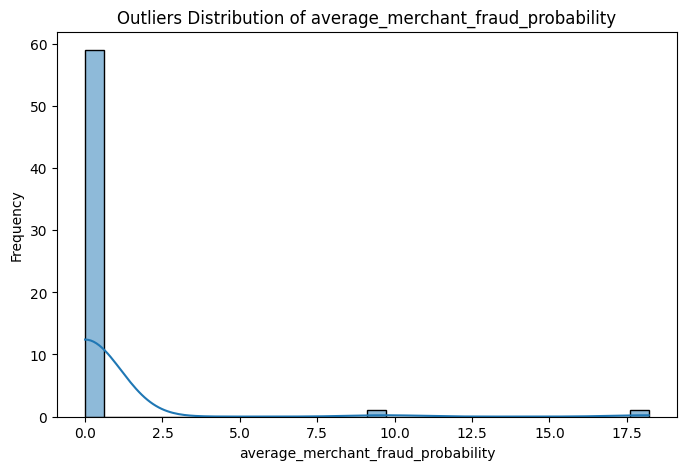

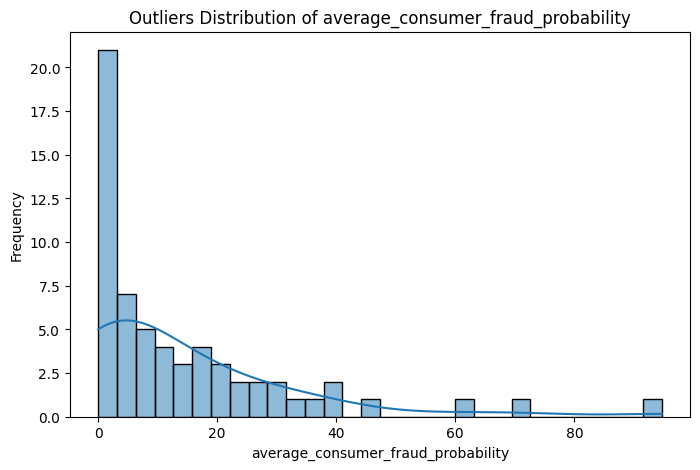

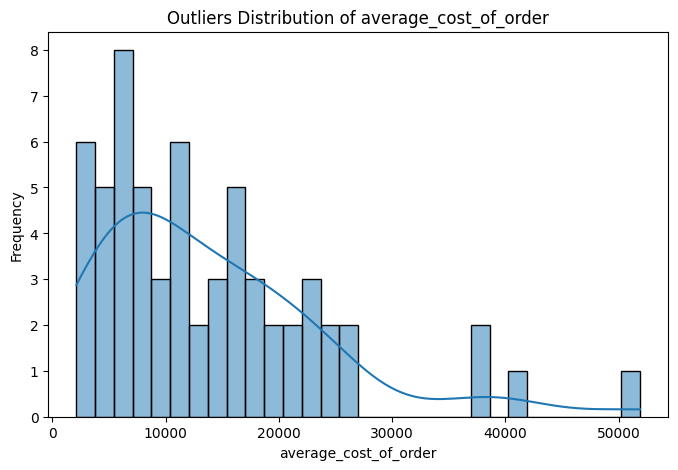

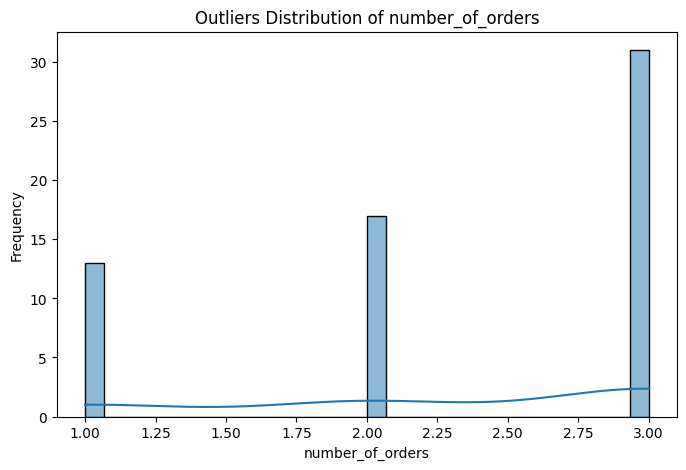

In [6]:
columns_to_plot = ['average_merchant_fraud_probability', 'average_consumer_fraud_probability','average_cost_of_order']

for col in columns_to_plot + ['number_of_orders']:
    plt.figure(figsize=(8,5))
    sns.histplot(outliers_df[col], kde=True, bins=30)  # you can adjust the number of bins as needed
    plt.title(f'Outliers Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')
    plt.show()

In [7]:
df_pandas_cleaned = df_pandas.loc[df_pandas['number_of_orders'] > lower_bound]
print("outliers removed length:", len(df_pandas_cleaned))

outliers removed length: 3965


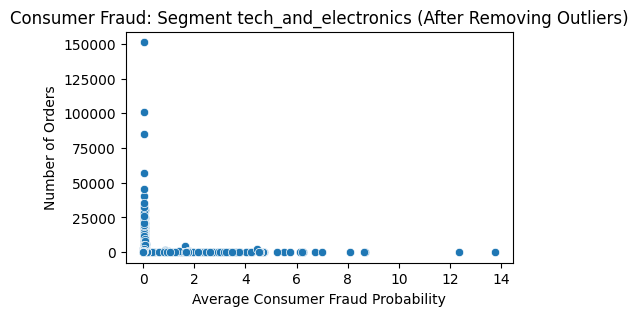

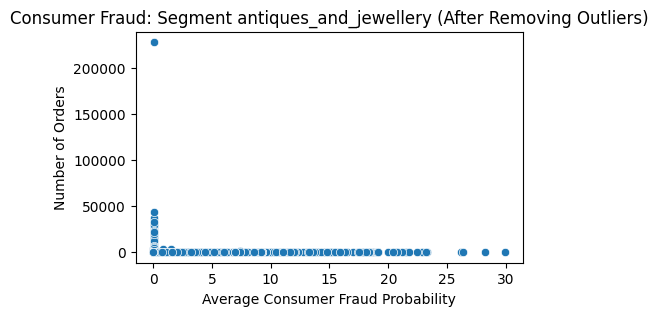

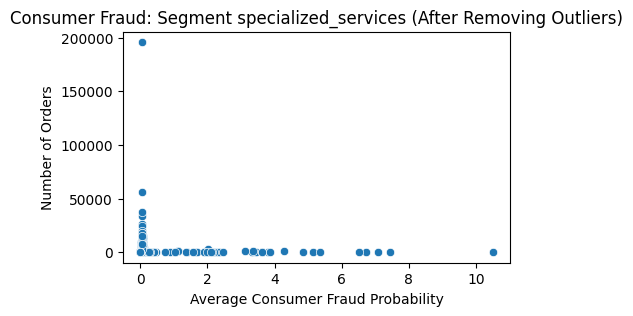

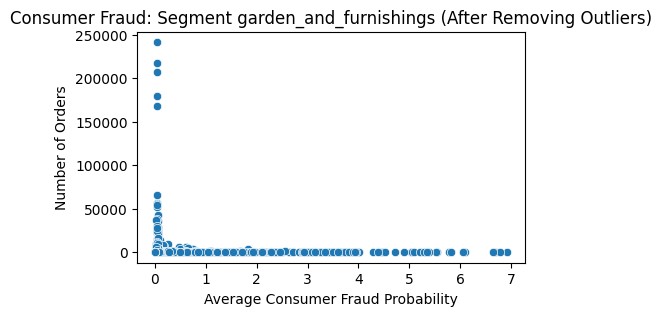

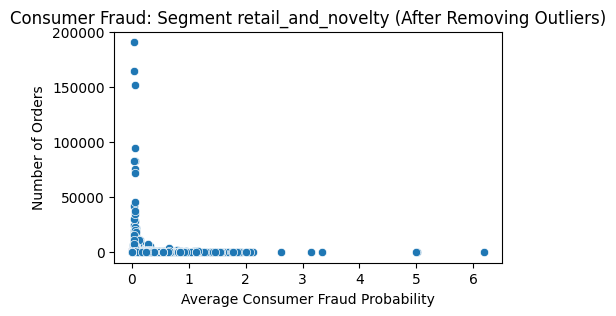

In [8]:
# Loop through each segment and plot
for segment in df_pandas_cleaned['segment'].unique():
    segment_df = df_pandas_cleaned[df_pandas_cleaned['segment'] == segment]

    # Filter the cleaned dataframe for each segment    
    # Plotting the scatter plot for merchant fraud
    plt.figure(figsize=(5,3))
    sns.scatterplot(x='average_consumer_fraud_probability', y='number_of_orders', data=segment_df)
    plt.title(f'Consumer Fraud: Segment {segment} (After Removing Outliers)')
    plt.xlabel('Average Consumer Fraud Probability')
    plt.ylabel('Number of Orders')
    plt.show()


Summary Statistics for average_consumer_fraud_probability:

count    3965.000000
mean        0.817982
std         2.641162
min         0.000000
25%         0.023436
50%         0.054380
75%         0.193124
max        29.968971
Name: average_consumer_fraud_probability, dtype: float64

--------------------------------------------------



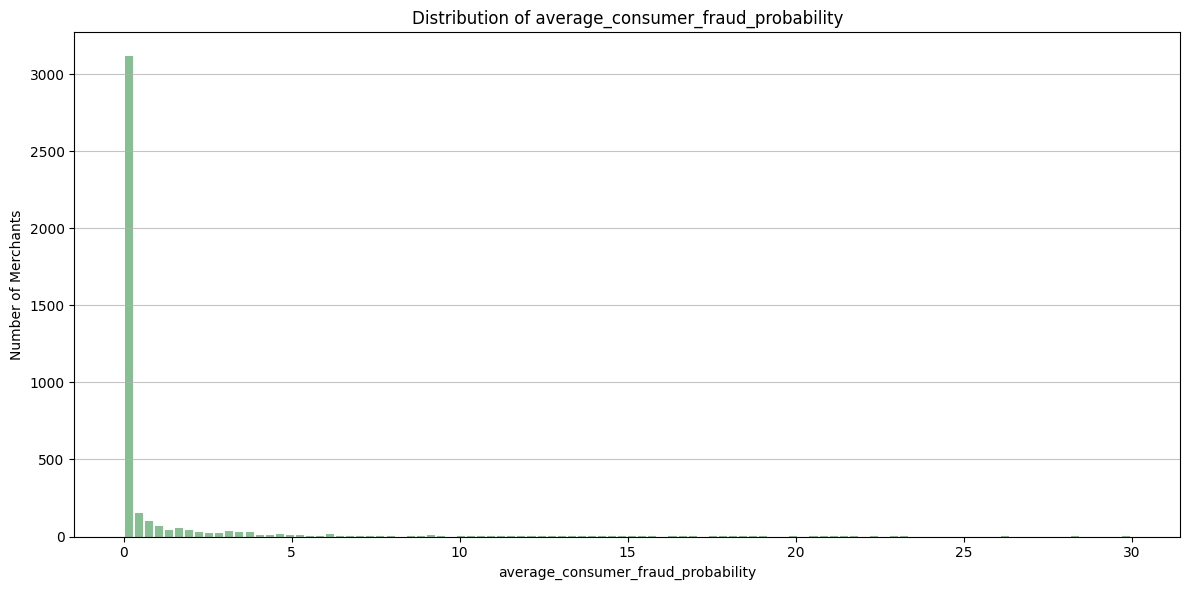

Summary Statistics for avg_median_age:

count    3965.000000
mean       43.111765
std         0.778923
min        36.800000
25%        42.917910
50%        43.107091
75%        43.297030
max        50.500000
Name: avg_median_age, dtype: float64

--------------------------------------------------



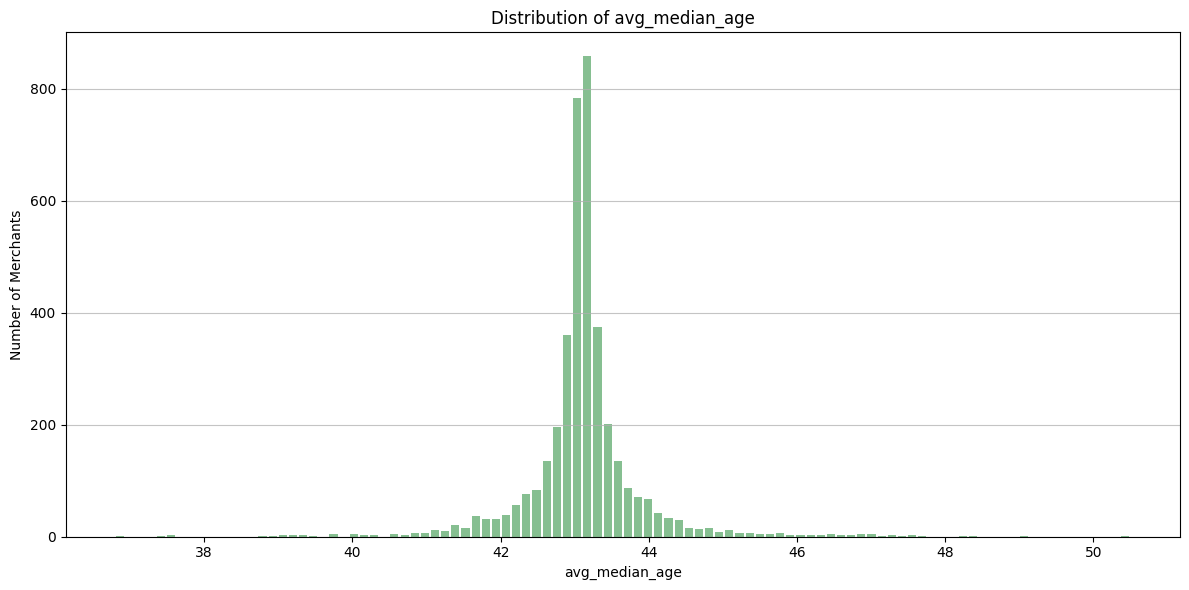

Summary Statistics for avg_total_weekly_personal_income:

count    3965.000000
mean      789.913466
std        25.799114
min       607.000000
25%       783.161473
50%       790.173236
75%       796.571918
max      1165.900000
Name: avg_total_weekly_personal_income, dtype: float64

--------------------------------------------------



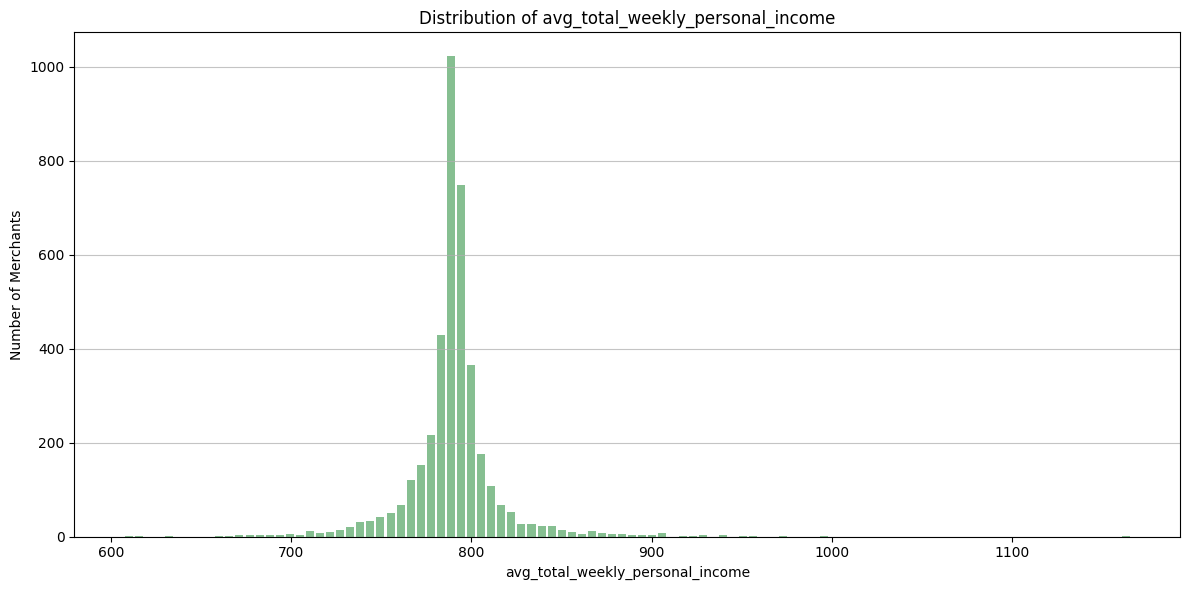

Summary Statistics for take_rate:

count    3965.000000
mean        4.404149
std         1.783473
min         0.100000
25%         2.980000
50%         4.510000
75%         6.040000
max         7.000000
Name: take_rate, dtype: float64

--------------------------------------------------



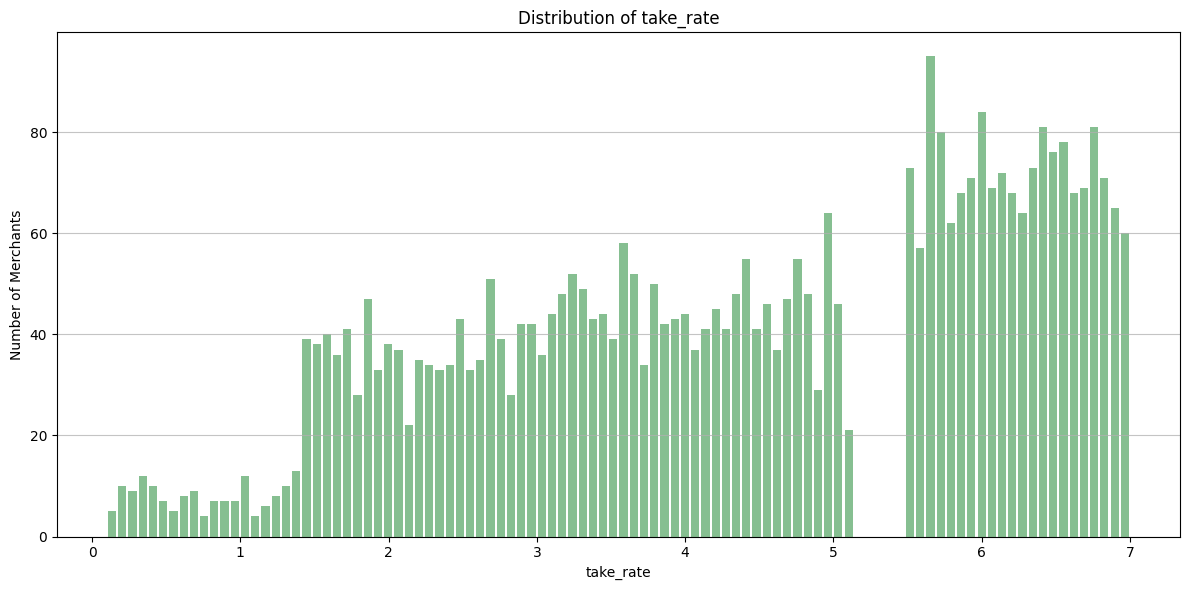

Summary Statistics for average_cost_of_order:

count     3965.000000
mean       966.292076
std       2205.253359
min          7.579026
25%        117.174737
50%        308.998755
75%        766.193571
max      28754.635714
Name: average_cost_of_order, dtype: float64

--------------------------------------------------



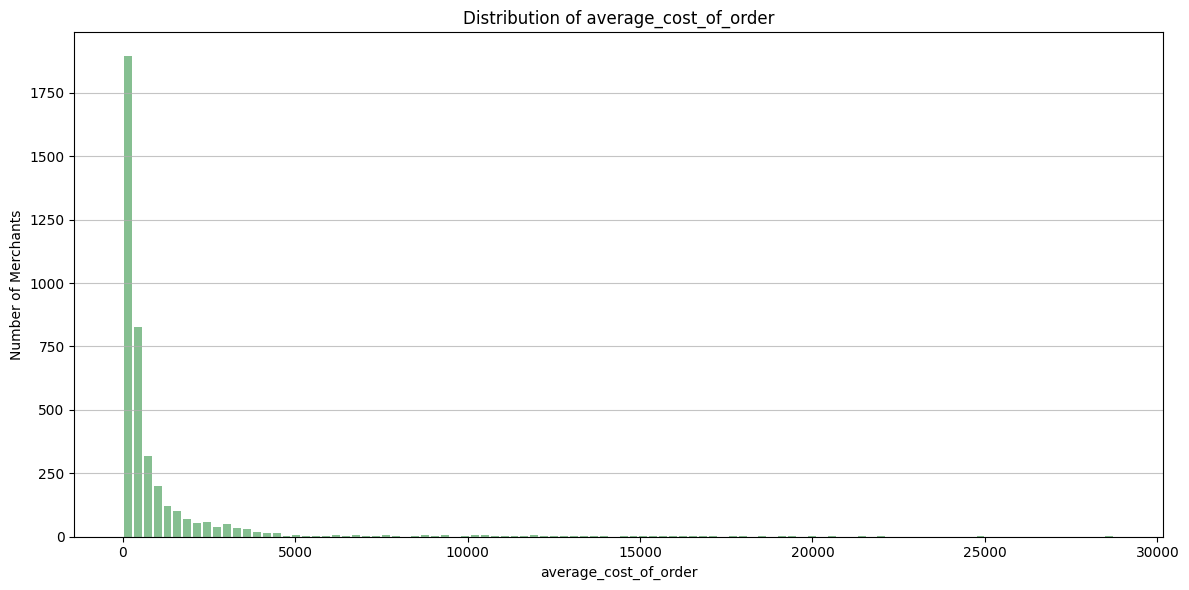

Summary Statistics for number_of_orders:

count      3965.000000
mean       2868.248424
std       11902.000660
min           4.000000
25%          84.000000
50%         363.000000
75%        1751.000000
max      241547.000000
Name: number_of_orders, dtype: float64

--------------------------------------------------



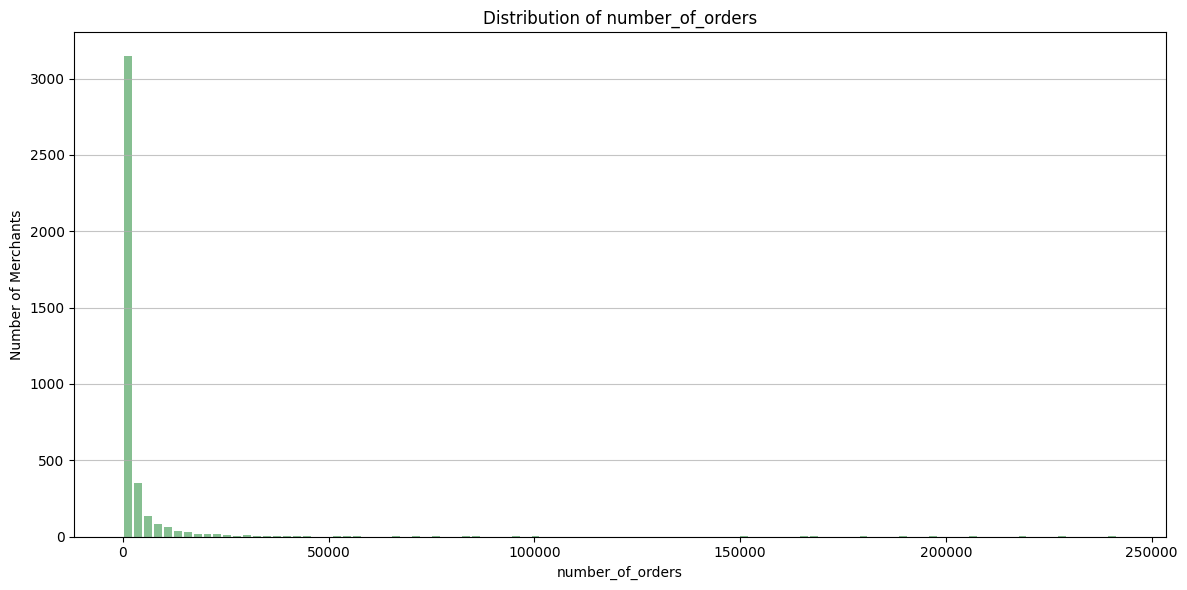

Summary Statistics for number_of_unique_consumers:

count     3965.000000
mean      1717.653468
std       3254.927401
min          4.000000
25%         84.000000
50%        359.000000
75%       1680.000000
max      20115.000000
Name: number_of_unique_consumers, dtype: float64

--------------------------------------------------



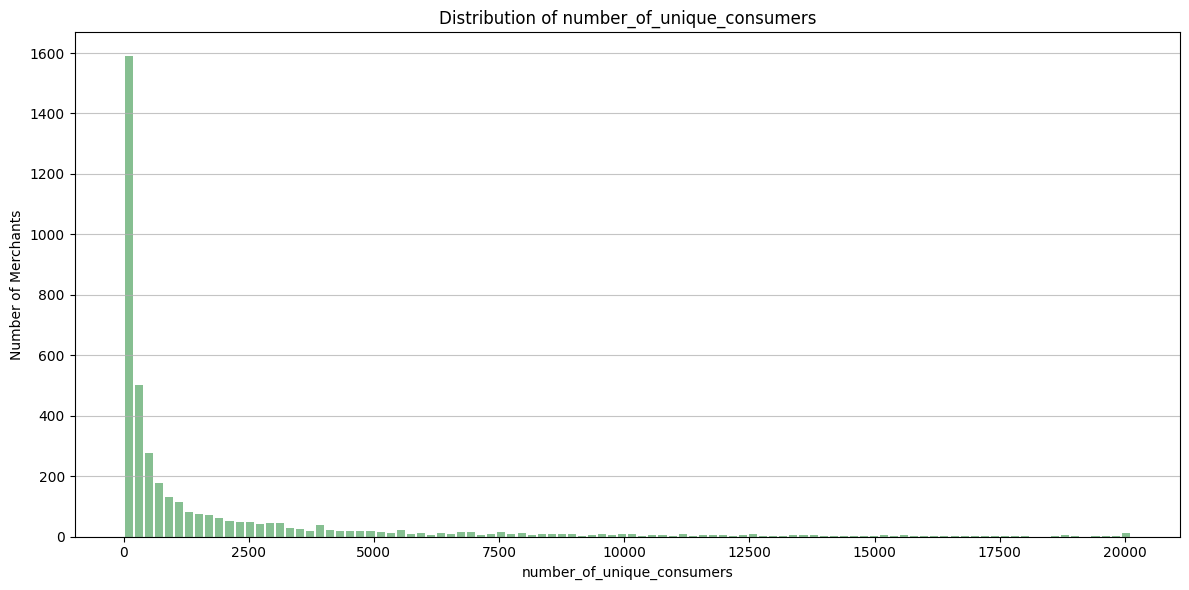

Summary Statistics for average_merchant_fraud_probability:

count    3965.000000
mean        0.008530
std         0.102498
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         2.960385
Name: average_merchant_fraud_probability, dtype: float64

--------------------------------------------------



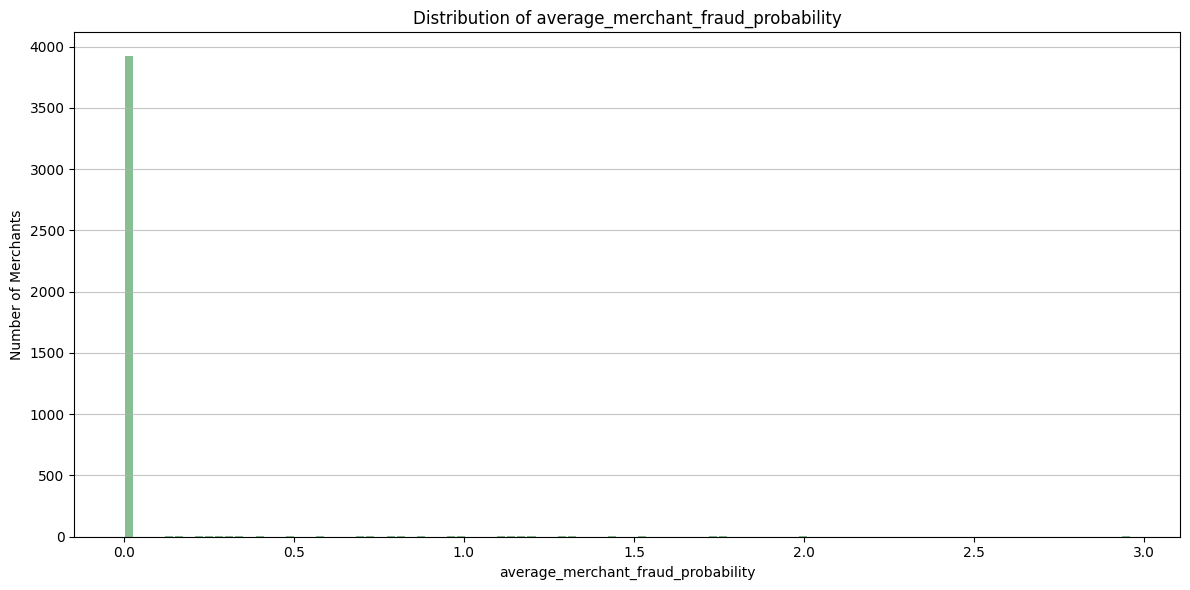

Summary Statistics for average_consumer_fraud_probability:

count    3965.000000
mean        0.817982
std         2.641162
min         0.000000
25%         0.023436
50%         0.054380
75%         0.193124
max        29.968971
Name: average_consumer_fraud_probability, dtype: float64

--------------------------------------------------



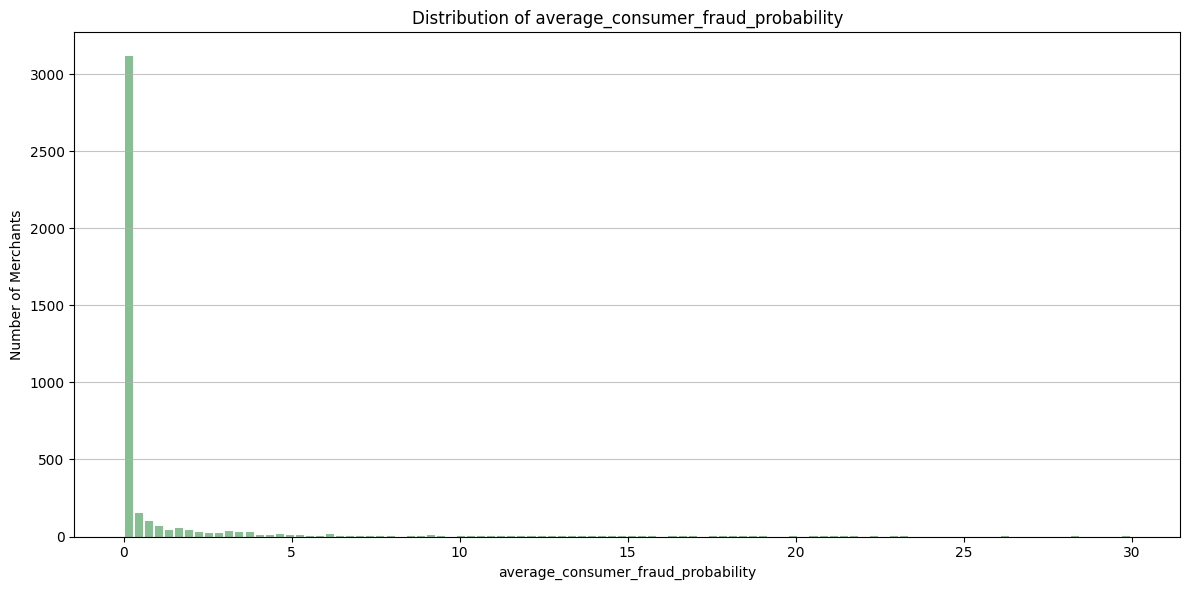

In [9]:
# List of columns to analyze
columns_to_analyze = [
    "average_consumer_fraud_probability", 
    "avg_median_age", 
    "avg_total_weekly_personal_income", 
    "take_rate", 
    "average_cost_of_order", 
    "number_of_orders", 
    "number_of_unique_consumers",
    "average_merchant_fraud_probability",
    "average_consumer_fraud_probability", 
]

df_pandas = df_pandas_cleaned
# For each column, calculate summary statistics and plot the distribution
for column in columns_to_analyze:
    summary_stats = df_pandas[column].describe()
    print(f"Summary Statistics for {column}:\n")
    print(summary_stats)
    print("\n" + "-"*50 + "\n")

    # Plot Distribution
    plt.figure(figsize=(12, 6))
    plt.hist(df_pandas[column], bins=100, color='#86bf91', rwidth=0.8)
    plt.title(f'Distribution of {column}')
    plt.xlabel(column)
    plt.ylabel('Number of Merchants')
    plt.grid(axis='y', alpha=0.75)
    plt.tight_layout()
    plt.show()

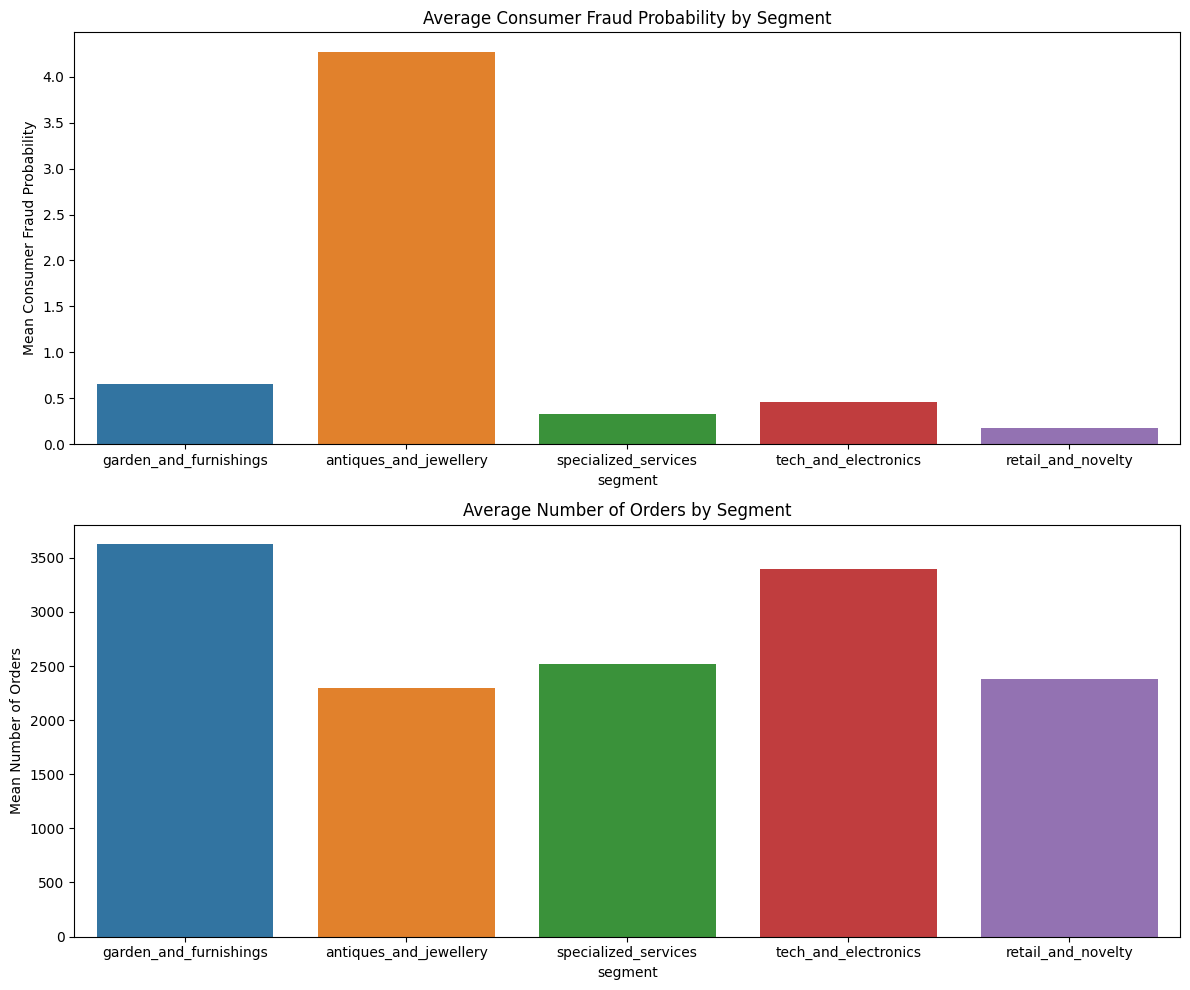

In [10]:
df = spark.createDataFrame(df_pandas_cleaned)
agg_data = df.groupBy("segment").agg(
    F.mean("average_consumer_fraud_probability").alias("mean_consumer_fraud"),
    F.stddev("average_consumer_fraud_probability").alias("stddev_consumer_fraud"),
    F.mean("number_of_orders").alias("mean_orders"),
    F.stddev("number_of_orders").alias("stddev_orders")
)

# Convert the aggregated data to Pandas DataFrame for visualization
agg_data_pandas = agg_data.toPandas()

# Plotting
fig, axes = plt.subplots(2, 1, figsize=(12, 10))

# Average consumer fraud probability by segment
sns.barplot(x="segment", y="mean_consumer_fraud", data=agg_data_pandas, ax=axes[0])
axes[0].set_title('Average Consumer Fraud Probability by Segment')
axes[0].set_ylabel('Mean Consumer Fraud Probability')

# Number of orders by segment
sns.barplot(x="segment", y="mean_orders", data=agg_data_pandas, ax=axes[1])
axes[1].set_title('Average Number of Orders by Segment')
axes[1].set_ylabel('Mean Number of Orders')

plt.tight_layout()
plt.show()

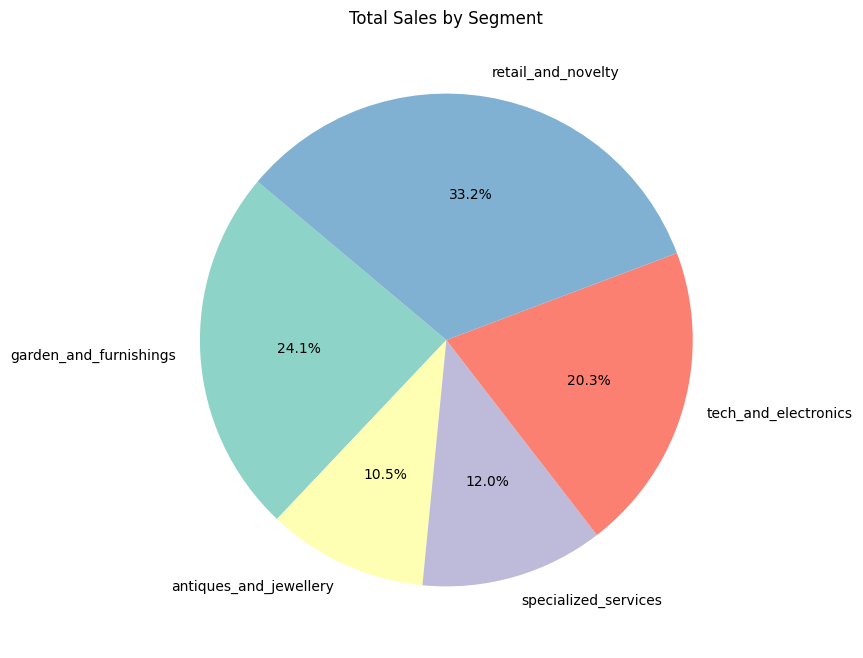

In [11]:
# Group by segment and aggregate total sales for each segment
agg_sales = df.groupBy("segment").agg(
    F.sum(df.number_of_orders * df.average_cost_of_order).alias("total_sales")
)

# Convert the aggregated data to a Pandas DataFrame for visualization
sales_pandas = agg_sales.toPandas()

# Plotting
plt.figure(figsize=(12, 8))
plt.pie(sales_pandas["total_sales"], labels=sales_pandas["segment"], autopct='%1.1f%%', startangle=140, colors=sns.color_palette("Set3", len(sales_pandas)))
plt.title('Total Sales by Segment')
plt.show()

In [12]:
df.write.mode('overwrite').parquet("../../../data/curated/removed_outliers.parquet")


In [13]:
spark.stop()